<a href="https://colab.research.google.com/github/kashindra-mahato/Computer-Vision/blob/main/%5BKerasCV%5D_Image_segmentation_with_a_U_Net_like_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 36.3 MB/s eta 0:00:00


In [ ]:
import random

import keras
import keras_cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

Using TensorFlow backend


In [ ]:
# Image Config
HEIGHT = 160
WIDTH = 160
NUM_CLASSES = 3

# Augmentation Config
ROTATION_FACTOR = (-0.2, 0.2)

# Training Config
BATCH_SIZE = 128
EPOCHS = 8 # 50 in tutorial
LEARNING_RATE = 1E-4
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Download the data
tfds.disable_progress_bar()
orig_train_ds, orig_val_ds = tfds.load(
    name="oxford_iiit_pet",
    split=["train+test[:80%]", "test[80%:]"],
)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
rescale_images_and_correct_masks = lambda inputs: {
    "images": tf.cast(inputs["image"], dtype=tf.float32) / 255.0,
    "segmentation_masks": inputs["segmentation_mask"] - 1,
}
train_ds = orig_train_ds.map(
    rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE
)
val_ds = orig_val_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

In [ ]:
# Utility function
def unpackage_inputs(inputs):
  image = inputs["images"]
  segmentation_masks = inputs["segmentation_masks"]
  return image, segmentation_masks

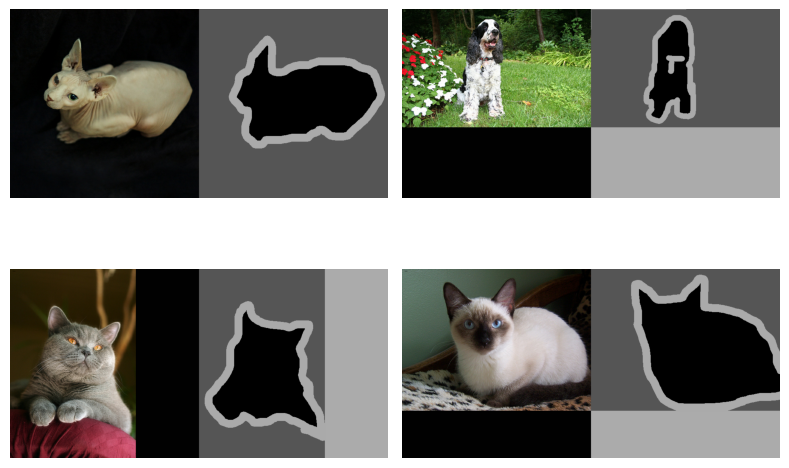

In [ ]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(4)
images, segmentation_masks = next(iter(plot_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0,1),
    num_classes=3,
    y_true = segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

In [ ]:
# Data augmentation
resize_fn = keras_cv.layers.Resizing(
    HEIGHT,
    WIDTH,
)
augment_fn = keras.Sequential(
    [
        resize_fn,
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomRotation(
            factor=ROTATION_FACTOR,
            segmentation_classes=NUM_CLASSES,
        ),
        # keras_cv.layers.RandAugment(
        #     value_range=(0, 1),
        #     geometric=False,
        # ),
    ]
)

In [ ]:
# Create training and validation datasets
augmented_train_ds = (
    train_ds.shuffle(BATCH_SIZE * 2)
    .map(augment_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

resized_val_ds = (
    val_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

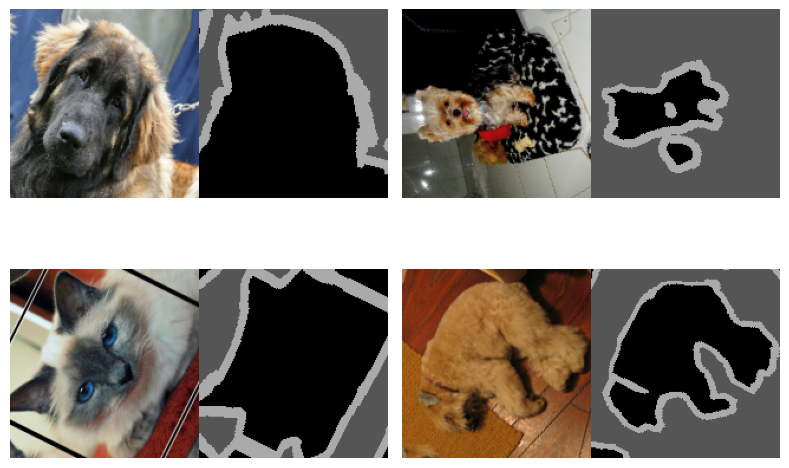

In [ ]:
images, segmentation_masks = next(iter(augmented_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

In [ ]:
# Model architecture - U Net
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))

  ## [First half of the network: downsampling inputs] ##

  # Entry block
  x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  previous_block_activation = x # Set aside the residual

  # Blocks 1, 2, 3 are identical apart from the feature depth
  for filters in [64, 128, 256]:
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation("relu")(x)
    x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = keras.layers.add([x, residual]) # Add back residual
    previous_block_activation = x # Set aside the next residual

  ## [Second half of the network: upsampling inputs] ##

  for filters in [256, 128, 64, 32]:
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.UpSampling2D(2)(x)

    # Project residual
    residual = keras.layers.UpSampling2D(2)(previous_block_activation)
    residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
    x = keras.layers.add([x, residual]) # Add back residual
    previous_block_activation = x # Set aside next residual

  # Add a per-pixel classification layer
  outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
# Taking a batch of test inputs to measure model's progress
test_images, test_masks = next(iter(resized_val_ds))

In [ ]:
class DisplayCallback(keras.callbacks.Callback):
  def __init__(self, epoch_interval=None):
    self.epoch_interval = epoch_interval

  def on_epoch_end(self, epoch, logs=None):
    if self.epoch_interval and epoch % self.epoch_interval == 0:
      pred_masks = self.model.predict(test_images)
      pred_masks = tf.math.argmax(pred_masks, axis=-1)
      pred_masks = pred_masks[..., tf.newaxis]

      # Randomly select an image from the test batch
      random_index = random.randint(0, BATCH_SIZE-1)
      random_image = test_images[random_index]
      random_pred_mask = pred_masks[random_index]
      random_true_mask = test_masks[random_index]

      fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
      ax[0].imshow(random_image)
      ax[0].set_title(f"Image: {epoch:03d}")

      ax[1].imshow(random_true_mask)
      ax[1].set_title(f"Ground Truth mask: {epoch:03d}")

      ax[2].imshow(random_pred_mask)
      ax[2].set_title(f"Predicted Mask: {epoch:03d}")
      plt.show()
      plt.close()

callbacks = [DisplayCallback(5)]

Epoch 1/8
4/4 [==============================] - 11s 3s/step


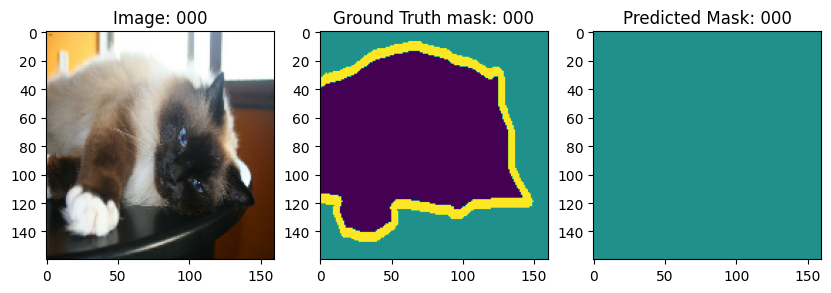

52/52 [==============================] - 2041s 39s/step - loss: 1.1844 - accuracy: 0.6293 - val_loss: 1.3502 - val_accuracy: 0.5740
Epoch 2/8
52/52 [==============================] - 1894s 36s/step - loss: 0.7833 - accuracy: 0.6917 - val_loss: 2.4524 - val_accuracy: 0.5740
Epoch 3/8
52/52 [==============================] - 1914s 37s/step - loss: 0.7171 - accuracy: 0.7118 - val_loss: 3.5941 - val_accuracy: 0.5740
Epoch 4/8
35/52 [===================>..........] - ETA: 9:59 - loss: 0.6924 - accuracy: 0.7194 

In [ ]:
# Train the model
# build model
model = get_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# train the model, doing validation at the end of the epoch
history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    validation_data=resized_val_ds,
    callbacks=callbacks,
)

In [ ]:
# Prediction with trained model
pred_masks = model.predict(test_images)
pred_masks = tf.math.argmax(pred_masks, axis=1)[..., None]

keras_cv.visualization.plot_segmentation.mask_gallery(
    test_images,
    value_range=(0, 1),
    num_classes=3,
    y_true=test_masks,
    y_pred=pred_masks,
    scale=4,
    rows=2,
    cols=2
)